In [2]:
from collections import defaultdict
%load_ext autoreload
%autoreload 2


import os
import sys
from typing import List, Dict, Optional, Any, Callable, Tuple
from tqdm import tqdm

%matplotlib inline
import time
import pylab as plt
from IPython import display
plt.style.use('bmh')
# plt.style.use('dark_background')
import seaborn as sns
sns.set(style="ticks")

import torch
import torch.nn.functional as F
import pandas as pd

project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)

from badger_utils.sacred import SacredReader, SacredUtils
from badger_utils.sacred.sacred_config import SacredConfigFactory
from torch import Tensor, optim
from badger_utils.view.observer_utils import MultiObserver, CompoundObserver, ObserverLevel, Observer

from bokeh.plotting import figure, show, output_notebook

output_notebook()


from gtn.datasets.datasets import Datasets
from gtn.models.learning_loop import LearningLoop, TrainData
from gtn.models.mnist_learner import MNISTLearnerConfig, MNISTLearner
from gtn.models.mnist_teacher import MNISTTeacher
from experiments.mnist_experiment import Config, create_teacher, create_learner_factory
from experiments.utils_ntb import plot_images, generate_teacher_images_for_class, load_teacher, generate_teacher_curriculum_images, plot_df

    
sacred_utils = SacredUtils(SacredConfigFactory.local())
if not os.path.exists('out'):
    os.mkdir('out')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [3]:
def shuffle(t: Tensor) -> Tensor:
    size = t.shape[0]
    return t[torch.randperm(size)]

def run_training_step(teacher: MNISTTeacher, c: Config, input_data: Tensor) -> CompoundObserver:
    learner_factory = create_learner_factory(c)
    # train_data = TrainData(lambda: shuffle(teacher.input_data) if shuffle_inputs else teacher.input_data, teacher.input_target)
    train_data = TrainData(lambda: input_data, teacher.input_target)
    test_loader = Datasets.mnist_dataloader(c.batch_size, train=False)
    learning_loop = LearningLoop(teacher, learner_factory, train_data, test_loader, learning_rate=c.learning_rate,
                                 learning_rate_learner=c.learning_rate_learner, train_samples=c.train_samples)

    observer = CompoundObserver(ObserverLevel.training)
    learning_loop.train_step(observer, c.inner_loop_steps, c.mnist_classes)
    return observer

def compare_shuffle(run_id: int, epoch: int):
    teacher, config = load_teacher(run_id, epoch)    
    dict1 = run_training_step(teacher, config, teacher.input_data).main.scalars_as_dict()
    teacher, config = load_teacher(run_id, epoch)    
    dict2 = run_training_step(teacher, config, shuffle(teacher.input_data)).main.scalars_as_dict()
    return dict1['accuracy'], dict2['accuracy']

def compare_shuffle_fixed(run_id: int, epoch: int):
    reader = sacred_utils.get_reader(run_id)
    teacher_input = reader.load_tensor('teacher_input.pt', epoch)
    teacher, config = load_teacher(run_id, epoch)    
    dict1 = run_training_step(teacher, config, teacher_input).main.scalars_as_dict()
    teacher, config = load_teacher(run_id, epoch)    
    dict2 = run_training_step(teacher, config, shuffle(teacher_input)).main.scalars_as_dict()
    return dict1['accuracy'], dict2['accuracy']

def load_random_fixed_teacher(run_id: int, epoch: int) -> Tuple[MNISTTeacher, Config]:
    reader = sacred_utils.get_reader(run_id)
    teacher_input = reader.load_tensor('teacher_input.pt', epoch)
    teacher, config = load_teacher(run_id, epoch)
    teacher._input_data = teacher_input
    return teacher, config

In [4]:
# sacred_run_id, epoch
run_id_random= 2512, 5000
run_id_learned = 2504, 5000
run_id_random_fixed = 2505, 5000

file_prefix = "t_20i_32b_"
bs = 32

In [5]:
# sacred_run_id, epoch
run_id_random= 2513, 4000
run_id_learned = 2506, 4000
run_id_random_fixed = 2507, 4000

file_prefix = "t_10i_32b_"
bs = 32

In [6]:
# sacred_run_id, epoch
run_id_random= 2514, 5000
run_id_learned = 2508, 5000
run_id_random_fixed = 2509, 5000

file_prefix = "t_10i_16b_"
bs = 16

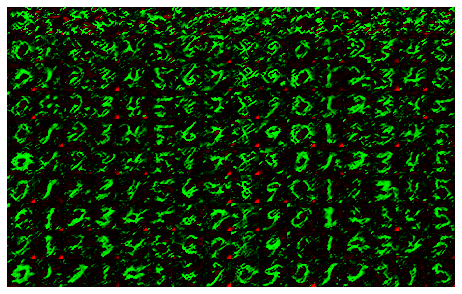

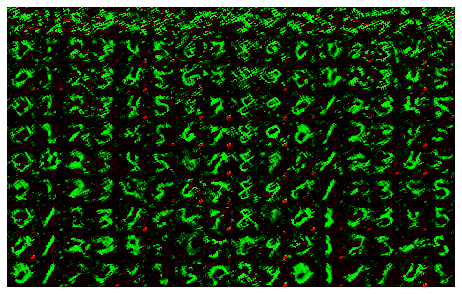

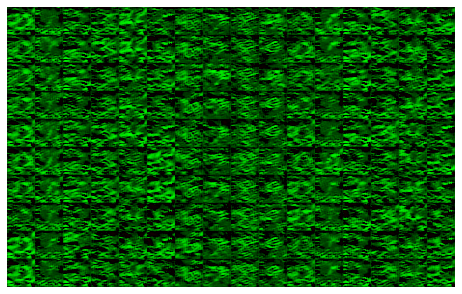

In [7]:
data, target = generate_teacher_curriculum_images(*load_random_fixed_teacher(*run_id_random_fixed))
plot_images(data, bs).savefig(f'out/{file_prefix}data_random_fixed.png')

data, target = generate_teacher_curriculum_images(*load_teacher(*run_id_learned))
plot_images(data, bs).savefig(f'out/{file_prefix}data_learned.png')
data, target = generate_teacher_curriculum_images(*load_teacher(*run_id_random))
plot_images(data, bs).savefig(f'out/{file_prefix}data_random.png')

# run_training_step(teacher, config, teacher.input_data).main.scalars_as_dict()

In [8]:
cur_result = defaultdict(list)
for i in tqdm(range(100)):
#     print(f"Iter {i+1}")
    result = {
        'random_fixed': compare_shuffle_fixed(*run_id_random_fixed),
        'random': compare_shuffle(*run_id_random),
        'learned': compare_shuffle(*run_id_learned)
    }
    for key, (acc, acc_shuffled) in result.items():
        cur_result[f'{key}'].append(acc)
        cur_result[f'{key}_shuffled'].append(acc_shuffled)
    
pd.DataFrame(cur_result).to_json(f'out/{file_prefix}teacher_input_shuffled_accuracy.json')

  0%|          | 0/3 [00:00<?, ?it/s]/home/phlubucek/opt/miniconda3/envs/gtn/lib/python3.7/site-packages/torch/nn/functional.py:1958: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."
100%|██████████| 3/3 [01:28<00:00, 29.61s/it]


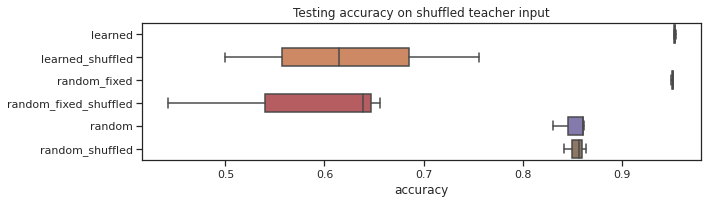

In [9]:
df = pd.read_json(f'out/{file_prefix}teacher_input_shuffled_accuracy.json')
df=df[
    [
       'learned',
       'learned_shuffled',
       'random_fixed',
       'random_fixed_shuffled',
       'random',
       'random_shuffled'
    ]
]
from matplotlib.ticker import AutoMinorLocator
fig = plt.figure(figsize=(10,3))
ax1 = sns.boxplot(data=df, orient='h')
ax1.grid(which='minor', axis='x', linewidth=1)
ax1.xaxis.set_label_text('accuracy')
ax1.set_title('Testing accuracy on shuffled teacher input')
fig.tight_layout()
fig.savefig(f'out/{file_prefix}teacher_input_shuffled.png')

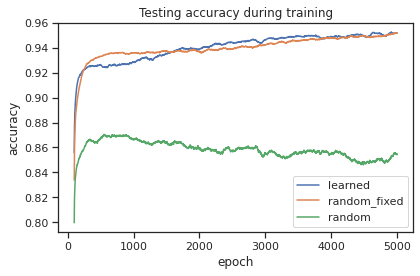

In [10]:
run_ids = [x[0] for x in [run_id_learned, run_id_random_fixed, run_id_random]]
accuracy = sacred_utils.load_metrics(run_ids, 'accuracy', 100)
# accuracy.plot()
fig = plt.figure(figsize=(6,4))
ax1 = sns.lineplot(data=accuracy.rename(columns={
    run_id_learned[0]: 'learned',
    run_id_random_fixed[0]: 'random_fixed',
    run_id_random[0]: 'random',
}), dashes=False)
ax1.yaxis.set_label_text('accuracy')
ax1.xaxis.set_label_text('epoch')
ax1.set_title('Testing accuracy during training')
fig.tight_layout()
fig.savefig(f'out/{file_prefix}teacher_input_loss.png')